In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext autoreload

%autoreload 1

In [37]:
import numpy as np
import pandas as pd

import pickle

from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt

# Load data

In [4]:
data_root = Path.home() / "data" / "tmp"
reuters_dir = data_root / "reuters21578"
reuters_corpus_path = reuters_dir / "corpus.pkl"
reuters = pickle.load(open(str(reuters_corpus_path), "rb"))
top_ten_ids, top_ten_names = reuters.top_n(n=10)

cache_dir = reuters_dir / "cache"

# Build dataframe

In [5]:
df, top_ten_ids, train_labels, test_labels = reuters.build_dataframe()

In [6]:
df.head()

,modapte,category,label,date,title,dateline,body,newid,wd_name
0,train,earn,1,1987-04-01 11:04:07,REPUBLIC SAVINGS AND LOAN <RSLA> SETS DIVIDEND,"MILWAUKEE, Wis., April 1 -\n",Qtly div 30 cts vs 30 cts prior\n Pay April...,12001,Wednesday
1,train,grain,5,1987-04-01 11:04:40,SHULTZ USSR TRIP FUELS TALK OF EEP WHEAT OFFER,"WASHINGTON, April 1 -",Speculation the United States will\noffer subs...,12002,Wednesday
2,train,sugar,19,1987-04-01 11:05:07,KAINES CONFIRMS WHITE SUGAR SALES TO INDIA,"LONDON, April 1 -",London-based sugar operator Kaines Ltd\nconfir...,12003,Wednesday
3,train,earn,1,1987-04-01 11:09:11,<THL HOLDINGS INC> YEAR JAN 31 NET,"CANTON, Mass., April 1 -\n",Oper net 94.4 mln vs 74.1 mln\n Revs 1.3 bi...,12005,Wednesday
4,train,acq,0,1987-04-01 11:09:50,MOUNTAIN STATES ADDS TWO MINERALS PROPERTIES,"SALT LAKE CITY, April 1 -",Mountain States Resources Corp\nsaid it acquir...,12007,Wednesday


# Build feature extraction pipeline

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.feature_extraction import DictVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC

In [8]:
from ds_tutorial.transformers import TextFromColumns, TextStats, ColumnSelector, TextFromColumns2

In [9]:
df_train = df.query("modapte == 'train'")
df_test = df.query("modapte == 'test'")
y_train = df_train.label.values
y_test = df_test.label.values

In [23]:
pipeline = Pipeline(memory=str(cache_dir), steps=[
    ("union", FeatureUnion(transformer_list=[
        ("title_stats", Pipeline([
            ("column", ColumnSelector("title")),
            ("stats", TextStats()),
            ("scaled", StandardScaler()),
        ])),
        ("body_stats", Pipeline([
            ("column", ColumnSelector("body")),
            ("stats", TextStats()),
            ("scaled", StandardScaler()),
        ])),
        ("combined_text", Pipeline([
            ("column", TextFromColumns2()),
            #("tfidf", TfidfVectorizer(analyzer="char_wb", ngram_range=(1, 5))),
            ("tfidf", TfidfVectorizer()),
            ("best", TruncatedSVD(n_components=300, random_state=2018))
        ])),

    ])),
])

In [24]:
%%time
X_train = pipeline.fit_transform(df_train)
X_test = pipeline.transform(df_test)

CPU times: user 18 s, sys: 1.49 s, total: 19.5 s
Wall time: 8.27 s


## Build multi layer perceptron

In [25]:
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

In [26]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))
    
    model.add(Dense(units=num_classes, activation="softmax"))
    return model

In [27]:
model = mlp_model(3, 32, 0.2, X_train.shape[1:], 75)

In [28]:
optimizer = Adam(lr=1e-3)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['acc'])

In [31]:
history = model.fit(X_train, y_train, epochs=70)

Epoch 1/70
7770/7770 [==============================] - 0s 51us/step - loss: 0.8793 - acc: 0.7663
Epoch 2/70
7770/7770 [==============================] - 0s 48us/step - loss: 0.8704 - acc: 0.7644
Epoch 3/70
7770/7770 [==============================] - 0s 49us/step - loss: 0.8440 - acc: 0.7687
Epoch 4/70
7770/7770 [==============================] - 0s 49us/step - loss: 0.8185 - acc: 0.7793
Epoch 5/70
7770/7770 [==============================] - 0s 63us/step - loss: 0.8116 - acc: 0.7788
Epoch 6/70
7770/7770 [==============================] - 1s 71us/step - loss: 0.7795 - acc: 0.7855
Epoch 7/70
7770/7770 [==============================] - 1s 72us/step - loss: 0.7617 - acc: 0.7909
Epoch 8/70
7770/7770 [==============================] - 0s 52us/step - loss: 0.7623 - acc: 0.7900
Epoch 9/70
7770/7770 [==============================] - 0s 53us/step - loss: 0.7491 - acc: 0.7929
Epoch 10/70
7770/7770 [==============================] - 0s 51us/step - loss: 0.7423 - acc: 0.7950
Epoch 11/70
7770/77

In [42]:
y_pred = model.predict_classes(X_test)
print(classification_report(y_test, y_pred, target_names=top_ten_names, labels=top_ten_ids, digits=3))

             precision    recall  f1-score   support

       earn      0.971     0.989     0.980      1087
        acq      0.951     0.979     0.965       710
   money-fx      0.681     0.855     0.758       145
      grain      0.366     0.357     0.361        42
      crude      0.725     0.902     0.804       164
      trade      0.744     0.826     0.783       109
   interest      0.804     0.701     0.749       117
       ship      0.625     0.493     0.551        71
      wheat      0.648     0.636     0.642        55
       corn      0.405     0.667     0.504        45

avg / total      0.879     0.915     0.895      2545



In [30]:
y_pred = model.predict_classes(X_test)
print(classification_report(y_test, y_pred, target_names=top_ten_names, labels=top_ten_ids, digits=3))

             precision    recall  f1-score   support

       earn      0.965     0.984     0.974      1087
        acq      0.899     0.975     0.935       710
   money-fx      0.661     0.821     0.732       145
      grain      0.000     0.000     0.000        42
      crude      0.714     0.823     0.765       164
      trade      0.692     0.844     0.760       109
   interest      0.780     0.726     0.752       117
       ship      0.405     0.690     0.510        71
      wheat      0.440     0.673     0.532        55
       corn      0.340     0.711     0.460        45

avg / total      0.839     0.908     0.869      2545



In [155]:
y_pred = model.predict_classes(X_test)
print(classification_report(y_test, y_pred, target_names=top_ten_names, labels=top_ten_ids, digits=3))

             precision    recall  f1-score   support

       earn      0.975     0.986     0.981      1087
        acq      0.936     0.968     0.952       710
   money-fx      0.738     0.834     0.783       145
      grain      0.486     0.405     0.442        42
      crude      0.765     0.872     0.815       164
      trade      0.736     0.817     0.774       109
   interest      0.816     0.795     0.805       117
       ship      0.688     0.620     0.652        71
      wheat      0.760     0.691     0.724        55
       corn      0.706     0.800     0.750        45

avg / total      0.894     0.919     0.906      2545



In [28]:
%%time
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=top_ten_names, labels=top_ten_ids, digits=3))

             precision    recall  f1-score   support

       earn      0.975     0.988     0.981      1087
        acq      0.921     0.975     0.947       710
   money-fx      0.753     0.800     0.776       145
      grain      0.515     0.405     0.453        42
      crude      0.761     0.835     0.797       164
      trade      0.738     0.853     0.791       109
   interest      0.767     0.786     0.776       117
       ship      0.629     0.620     0.624        71
      wheat      0.776     0.691     0.731        55
       corn      0.630     0.756     0.687        45

avg / total      0.886     0.918     0.901      2545

CPU times: user 30.1 s, sys: 77.9 ms, total: 30.2 s
Wall time: 30.3 s


# Sequential model

In [10]:
X_train.shape[:]dd

SyntaxError: invalid syntax (<ipython-input-10-715f2fdc85bf>, line 1)

In [49]:
model = models.Sequential()
model.add(Embedding(
    input_dim=X_train.shape[1],
    input_shape=X_train.shape[1:],
    output_dim=32,
    input_length=X_train[0])
)

In [17]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [18]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

In [19]:
#TextFromColumns2().transform(df_train)

In [20]:
from tensorflow.python.keras.preprocessing import text
from tensorflow.python.keras.preprocessing import sequence

MAX_SEQUENCE_LENGTH = 500
TOP_K = 20000

tokenizer = text.Tokenizer(num_words=TOP_K)

train_text = TextFromColumns2().transform(df_train)
tokenizer.fit_on_texts(train_text)

X_train = tokenizer.texts_to_sequences(train_text)
test_text = TextFromColumns2().transform(df_test)
X_test = tokenizer.texts_to_sequences(test_text)

max_length = len(max(X_train, key=len))
if max_length > MAX_SEQUENCE_LENGTH:
    max_length = MAX_SEQUENCE_LENGTH

# Fix sequence length to max value. Sequences shorter than the length are
# padded in the beginning and sequences longer are truncated
# at the beginning.
X_train = sequence.pad_sequences(X_train, maxlen=max_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_length)

In [63]:
num_features = min(len(tokenizer.word_index) + 1, TOP_K)

In [64]:
X_train.shape, X_test.shape, num_features

((7770, 500), (3019, 500), 20000)

In [65]:
model = sepcnn_model(
    blocks=2,
    filters=64,
    kernel_size=3,
    embedding_dim=200,
    dropout_rate=0.2,
    pool_size=3,
    input_shape=X_train.shape[1:],
    num_classes=75,
    num_features=num_features
)

In [66]:
optimizer = Adam(lr=1e-3)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['acc'])

In [67]:
import tensorflow as tf
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

In [68]:
%%time
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    #callbacks=callbacks,
    batch_size=128
)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7770 samples, validate on 3019 samples
Epoch 1/100
7770/7770 [==============================] - 6s 739us/step - loss: 2.6886 - acc: 0.3319 - val_loss: 2.3779 - val_acc: 0.3760
Epoch 2/100
7770/7770 [==============================] - 5s 585us/step - loss: 2.3231 - acc: 0.4041 - val_loss: 2.0919 - val_acc: 0.4495
Epoch 3/100
7770/7770 [==============================] - 5s 583us/step - loss: 1.9468 - acc: 0.5287 - val_loss: 1.7966 - val_acc: 0.6042
Epoch 4/100
7770/7770 [==============================] - 5s 586us/step - loss: 1.6344 - acc: 0.5849 - val_loss: 1.5972 - val_acc: 0.6247
Epoch 5/100
7770/7770 [==============================] - 5s 583us/step - loss: 1.4859 - acc: 0.6165 - val_loss: 1.4256 - val_acc: 0.6558
Epoch 6/100
7770/7770 [==============================] - 5s 580us/step - loss: 1.3698 - acc: 0.6448 - val_loss: 1.4232 - val_acc: 0.6645
Epoch 7/100
7770/7770 [==============================] - 5s 583us/step - loss: 1.2705 - acc: 0.6741 - val_loss: 1.3227 - val_acc: 

7770/7770 [==============================] - 5s 591us/step - loss: 0.0889 - acc: 0.9761 - val_loss: 1.4095 - val_acc: 0.8132
Epoch 61/100
7770/7770 [==============================] - 5s 589us/step - loss: 0.0756 - acc: 0.9781 - val_loss: 1.4467 - val_acc: 0.8158
Epoch 62/100
7770/7770 [==============================] - 5s 592us/step - loss: 0.0847 - acc: 0.9788 - val_loss: 1.4117 - val_acc: 0.8105
Epoch 63/100
7770/7770 [==============================] - 5s 581us/step - loss: 0.0676 - acc: 0.9816 - val_loss: 1.4729 - val_acc: 0.8129
Epoch 64/100
7770/7770 [==============================] - 5s 587us/step - loss: 0.0654 - acc: 0.9822 - val_loss: 1.4885 - val_acc: 0.8105
Epoch 65/100
7770/7770 [==============================] - 5s 585us/step - loss: 0.0762 - acc: 0.9792 - val_loss: 1.5360 - val_acc: 0.8112
Epoch 66/100
7770/7770 [==============================] - 5s 582us/step - loss: 0.0680 - acc: 0.9811 - val_loss: 1.4947 - val_acc: 0.8089
Epoch 67/100
7770/7770 [=======================

In [69]:
import json

models_dir = data_root / "models" 
models_dir.mkdir(exist_ok=True)
model.save(models_dir / "reuters_sequential.h5")

history_path = models_dir / "reuters_sequential.json"
with open(str(history_path), "w") as f:
    json.dump(history.history, f)

In [70]:
history = json.load(open(str(history_path)))

In [71]:
y_pred = model.predict_classes(X_test)
print(classification_report(y_test, y_pred, target_names=top_ten_names, labels=top_ten_ids, digits=3))

             precision    recall  f1-score   support

       earn      0.960     0.983     0.972      1087
        acq      0.950     0.911     0.930       710
   money-fx      0.595     0.690     0.639       145
      grain      0.303     0.476     0.370        42
      crude      0.696     0.811     0.749       164
      trade      0.713     0.661     0.686       109
   interest      0.598     0.650     0.623       117
       ship      0.540     0.380     0.446        71
      wheat      0.722     0.473     0.571        55
       corn      0.508     0.667     0.577        45

avg / total      0.857     0.864     0.858      2545



# Plot training vs test accuracy

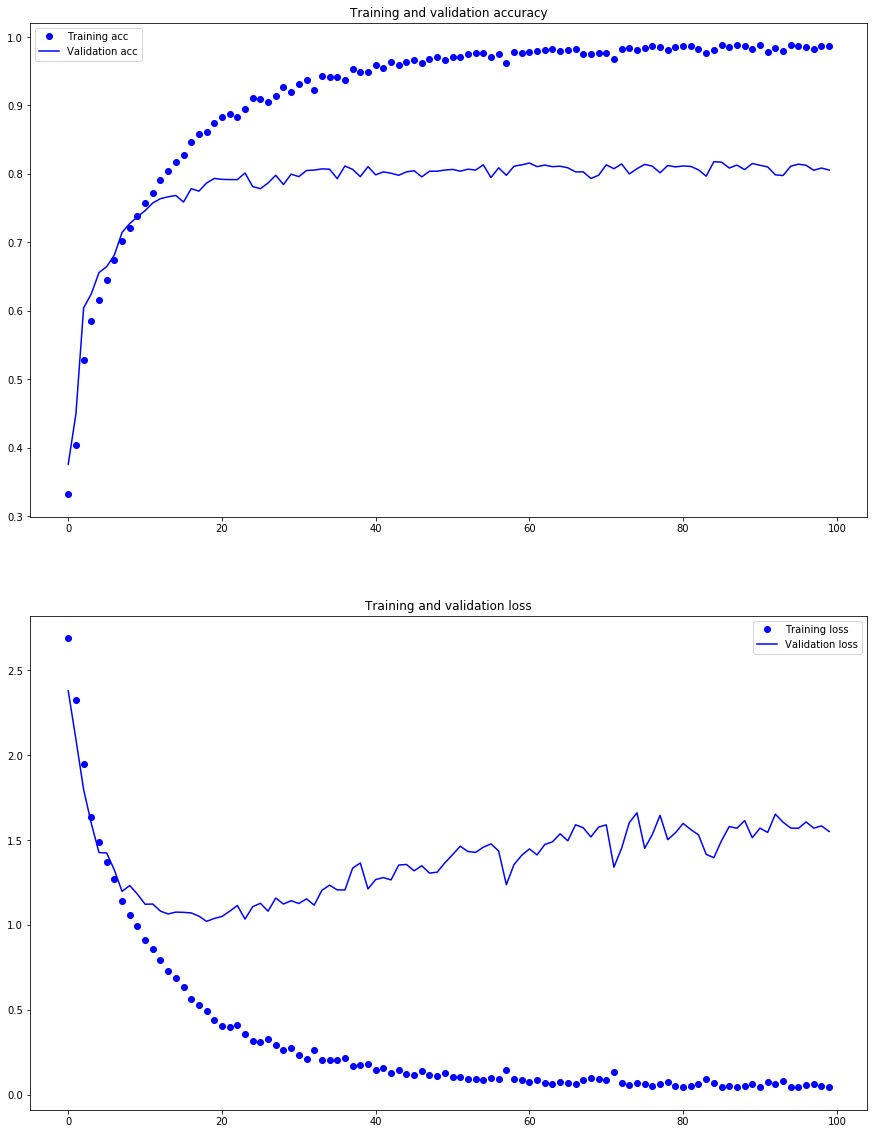

In [72]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15, 20))

plt.subplot(211)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(212)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()